<h1>Rocket Simulation</h1>
<p>Since the numbers are all so large here, it doesn't seem like a vpython application is the right move here. Instead, I'll use Matplotlib for visualization. The goal is to build up a successively complex rocket simulation that incorporates drag and other forces that I've learned about thus far in intro mechanics.</p>
<p>The performance of this rocket will be based loosley on the Delta II. For specs, I used the following source: https://www.spacelaunchreport.com/delta2.html.</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from rocket import Rocket, Stage
from vector import Vector
from math import exp, isclose
import json

{'cmds': [{'throttle': 50}]}
{'throttle': 50}
{'cmds': [{'throttle': 100}]}
{'throttle': 100}
{'cmds': [{'throttle': 0}]}
{'throttle': 0}


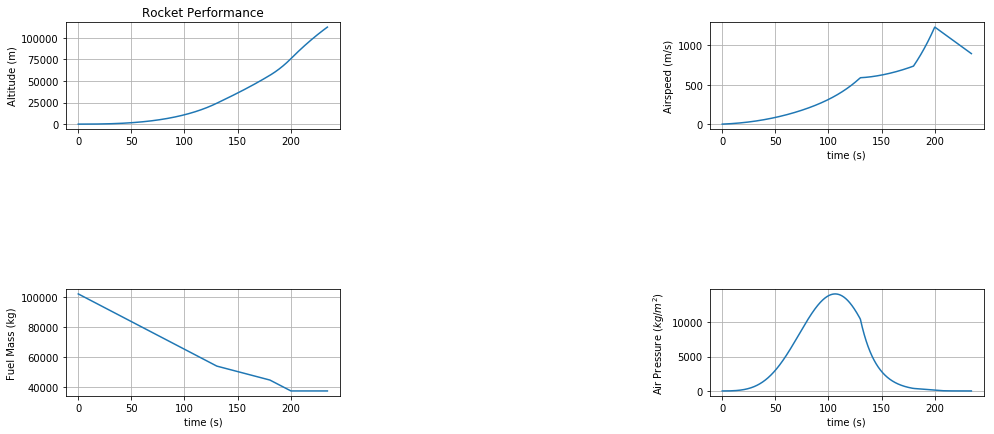

Max Q is 14083.99N/m^2.


In [2]:
# constants
g = 9.8 # acceleration due to gravity near the Earth's surface
dt = 0.01

# atmosphere
rho_air = lambda altitude: 1.225*exp(-altitude/8500)

# rocket properties
coeff_drag = 0.82 # long cylinder
A = np.pi*1.5**2 # 3m composite fairing cross-sectional area
max_dmdt = 368.98 #in kg/s. TODO: in phase 2, allow for throttling. Until then, the engine will burn flat out.
dry_mass = 5.680E3 # in kg
fuel_mass = 9.6120E4 # in kg
burn_time = 260.5 # TODO: burn time of main engine. temp var, will replace when dmdt != 0
pos = Vector(0,0,0)
momentum = Vector(0,0,0)
total_mass = 1.01800E5 # in kg
max_thrust_mag = 1.054000E6
fuel_consumption_rate = max_dmdt

# Create a rocket
deltaII = Rocket(pos, coeff_drag, A)
stage1 = Stage({"dry_mass": dry_mass, "fuel_mass": fuel_mass, "max_thrust_mag": max_thrust_mag, "max_dmdt": fuel_consumption_rate})
deltaII.add_stage(stage1)

# forces
Fgrav = Vector(0,-total_mass*g,0)
Fthrust = Vector(0,max_thrust_mag,0)

t = 0
idx = 0
data_point_counter = 0
total_data_points = 2605
data_time = np.zeros(total_data_points)
data_altitude = np.zeros(total_data_points)
data_velocity = np.zeros(total_data_points)
data_mass = np.zeros(total_data_points)
data_pressure = np.zeros(total_data_points)

max_Q = 0

# load flight plan from file
with open('flt-plan.json') as f:
  flt_plan = json.load(f)

def check_flt_plan(time):
    global flt_plan
    tm = "{:0.2f}".format(time)
    menu = next((d for i,d in enumerate(flt_plan) if tm in d), None)
    if menu is not None:
        # loop through instruction set
        menu = menu.get(tm)
        print(menu)
        cmds = menu.get("cmds", [])
        # loop through the commands in this menu and execute them in turn
        for cmd in cmds:
            print(cmd)
            if cmd["throttle"] is not None:
                adjust_throttle(cmd["throttle"])
    
def update_total_mass():
    global fuel_mass, total_mass, fuel_consumption_rate
    fuel_mass -= fuel_consumption_rate*dt
    total_mass = dry_mass + fuel_mass

def adjust_throttle(percent):
    global fuel_consumption_rate, Fthrust, max_dmdt
    throttle = percent/100
    fuel_consumption_rate = max_dmdt*throttle
    Fthrust = Vector(0,max_thrust_mag*throttle,0)

while t <= burn_time:
    
    # calculate net force on rocket
    Fgrav = Vector(0,-total_mass*g,0)
    velocity = momentum/total_mass
    
    if velocity.mag() > 0:
        Fdrag = -1/2*coeff_drag*A*rho_air(pos.y)*velocity.mag()**2*velocity.hat()
    else:
        Fdrag = Vector(0,0,0)
        
    Fnet = Fthrust + Fgrav + Fdrag
    
    # update the rocket's momentum
    momentum = momentum + Fnet*dt
    
    # update the rockets position
    pos = pos + momentum/total_mass*dt
    
    update_total_mass()
    
    # check flight plan for updates
    check_flt_plan(t)
    
    if data_point_counter == 9 and idx < total_data_points:
        data_point_counter = 0
        data_time[idx] = t
        data_altitude[idx] = pos.y
        data_velocity[idx] = (momentum/total_mass).mag()
        data_mass[idx] = total_mass
        data_pressure[idx] = Fdrag.mag()/A
        idx += 1
    
    data_point_counter += 1
    t += dt

plt.figure(figsize=(15, 15))
    
plt.subplot(4, 2, 1)
plt.plot(data_time, data_altitude)
plt.title('Rocket Performance')
plt.ylabel('Altitude (m)')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(data_time, data_velocity)
plt.xlabel('time (s)')
plt.ylabel('Airspeed (m/s)')
plt.grid(True)

plt.subplot(4, 2, 3)
plt.plot(data_time, data_mass)
plt.xlabel('time (s)')
plt.ylabel('Fuel Mass (kg)')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(data_time, data_pressure)
plt.xlabel('time (s)')
plt.ylabel('Air Pressure ($kg/m^2$)')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1.5, wspace=1.35)
plt.show()

max_Q = np.amax(data_pressure)
print("Max Q is {:0.2f}N/m^2.".format(max_Q))